<a href="https://colab.research.google.com/github/reza-latifi/Histogram-of-Oriented-Gradients/blob/main/HOG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

#Read image

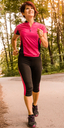

In [ ]:
# My image is 128*64. this method works only with this size.
# You need to first use cv2.resize(img, (64,128)) to resize your images.
img = cv2.imread('/content/drive/MyDrive/HOG_images/human1.jpg')
cv2_imshow(img)
scaled_img = np.float32(img) / 255.0

#Calculate gradient 

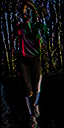

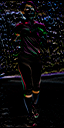

In [ ]:
gx = cv2.Sobel(scaled_img, cv2.CV_64F, 1, 0, ksize=1)
gy = cv2.Sobel(scaled_img, cv2.CV_64F, 0, 1, ksize=1)
cv2_imshow(gx*255)
cv2_imshow(gy*255)

# Find Magnitud and Agnle of Grdients

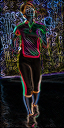

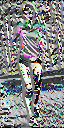

In [ ]:
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
cv2_imshow(mag*255/mag.max())
cv2_imshow(angle*255/360)

# Find unsigned gradient

In [ ]:
angle = angle % 180

# Create Hists

In [ ]:
def getBinVotes(angle):
  bin = int(angle / 20)
  if bin == 8:
    return {0: (angle - 160)/20, 8: 1 - (angle - 160)/20}
  return {bin: (20 - (angle - 20*bin))/20, bin+1: 1- (20 - (angle - 20*bin))/20}

In [ ]:
for i in range(0, 128, 8):
  cv2_imshow(img[i:i+8])

In [ ]:
hists = np.zeros((16 ,8, 9)) # 16 rows, 8 columns and 9 bins
mags = []
angles = []
channel = 0
binVotes = []
for i in range(16):
  for j in range(8):
    mags = mag[i*8:(i+1)*8+8, (j*8):(j+1)*8+8]
    angles = angle[i*8:(i+1)*8+8, (j*8):(j+1)*8+8]
    # now 8*8 cell is selected
    for column in range(len(angles)): # column of 8*8 cell
      for row in range(len(angles[column])): # row of 8*8 cell
        channel = np.argmax(mags[column][row]) # select channel with maximum magnitude
        binVotes = getBinVotes(angles[column][row][channel]) # bin votes of selected channel
        for bin in binVotes:
          hists[i][j][bin] += mags[column][row][channel] * binVotes[bin]

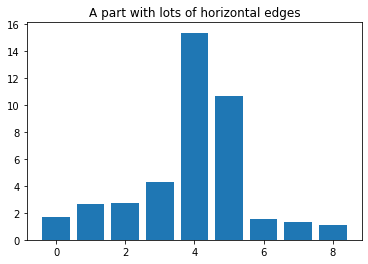

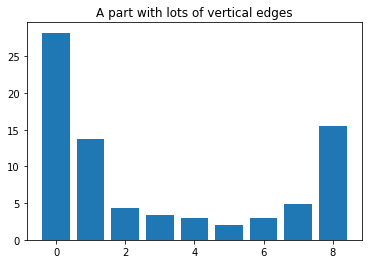

In [ ]:
plt.title("A part with lots of horizontal edges")
plt.bar(np.arange(9), hists[9][0])
plt.show()

plt.title("A part with lots of vertical edges")
plt.bar(np.arange(9), hists[10][3])
plt.show()

In [ ]:
HOG = []
block = []
for i in range(15):
  for j in range(7):
    # i, j indicated left, top block
    block = np.hstack((hists[i][j], hists[i][j+1], hists[i+1][j], hists[i+1][j+1]))
    block /= np.linalg.norm(block)
    HOG = np.hstack((HOG, block))

In [ ]:
HOG.shape

(3780,)

# Wrap up all the code abow in one function

In [ ]:
def getHOG(img):
  scaled_img = np.float32(img) / 255.0
  gx = cv2.Sobel(scaled_img, cv2.CV_64F, 1, 0, ksize=1)
  gy = cv2.Sobel(scaled_img, cv2.CV_64F, 0, 1, ksize=1)
  mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
  angle = angle % 180
  
  hists = np.zeros((16 ,8, 9)) # 16 rows, 8 columns and 9 bins
  mags = []
  angles = []
  channel = 0
  binVotes = []
  for i in range(16):
    for j in range(8):
      mags = mag[i*8:(i+1)*8+8, (j*8):(j+1)*8+8]
      angles = angle[i*8:(i+1)*8+8, (j*8):(j+1)*8+8]
      # now 8*8 cell is selected
      for column in range(len(angles)): # column of 8*8 cell
        for row in range(len(angles[column])): # row of 8*8 cell
          channel = np.argmax(mags[column][row]) # select channel with maximum magnitude
          binVotes = getBinVotes(angles[column][row][channel]) # bin votes of selected channel
          for bin in binVotes:
            hists[i][j][bin] += mags[column][row][channel] * binVotes[bin]
             
  HOG = []
  block = []
  for i in range(15):
    for j in range(7):
      # i, j indicated left, top block
      block = np.hstack((hists[i][j], hists[i][j+1], hists[i+1][j], hists[i+1][j+1]))
      block /= np.linalg.norm(block)
      HOG = np.hstack((HOG, block))
  return HOG

# Compare with SK-learn


In [ ]:
def similarity(first,second):
  return np.inner(first, second)/(np.linalg.norm(first)*np.linalg.norm(second))

In [ ]:
from skimage.feature import hog

cvHOG = hog(img, orientations=9, pixels_per_cell=(8,8),cells_per_block=(2, 2), block_norm='L1-sqrt')
myHOG = getHOG(img)
similarity(myHOG, cvHOG)
# The difference might be because of the different implementations.

0.8707884440535847

# Classify using HOG

In [ ]:
imgs = [
  cv2.imread('/content/drive/MyDrive/HOG_images/human2.jpg'),
  cv2.imread('/content/drive/MyDrive/HOG_images/human3.jpg'),
  cv2.imread('/content/drive/MyDrive/HOG_images/car1.jpg'),
  cv2.imread('/content/drive/MyDrive/HOG_images/car2.jpg'),
  cv2.imread('/content/drive/MyDrive/HOG_images/window.jpeg'),
]

for i in range(len(imgs)):
  imgs[i] = getHOG(cv2.resize(imgs[i], (64,128)))

labels = ['human', 'human', 'car', 'car', 'window']

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

clf = SVC(kernel='linear')

clf.fit(imgs, labels)

test = getHOG(cv2.resize(cv2.imread('/content/drive/MyDrive/HOG_images/human1.jpg'), (64,128)))

clf.predict([test])

array(['human'], dtype='<U6')